#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/kt/projects_kt/project_6/6/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [ ]:
from datetime import timedelta
import holidays
from sklearn.preprocessing import StandardScaler


In [ ]:
from datetime import timedelta
import holidays
from sklearn.preprocessing import StandardScaler
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)
def preproc3d(data, timesteps, y_scale = False) :
    x = data.drop(['Date','Date_2', 'target'], axis = 1)
    y = data.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])
    col_names = list(x)


    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val

def make_dataset(sales, orders, oil_price, Product_ID, Store_ID=44, y_scale=True, timesteps=7):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==Store_ID) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==Store_ID, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.weekday # 요일 추출 (0: 월요일, 6: 일요일)
    temp3['Month'] = temp3['Date'].dt.month
    temp3['Day']=temp3['Date'].dt.day

    # 2일뒤 요일
    temp3['Date_2']=temp3['Date']+timedelta(2)
    temp3['Day+2']=temp3['Date_2'].dt.day
    temp3['Weekday+2']=temp3['Date_2'].dt.weekday

    temp3['Qty_1ago'] = temp3['Qty'].shift(1) #1일전 매출
    temp3['Qty_2ago'] = temp3['Qty'].shift(2) #2일전 매출
    temp3['Qty_last week'] = temp3['Qty'].shift(7) #일주일전 매출

    # 평균 판매량(7일, 14일)
    temp3['MA_7'] = temp3['Qty'].rolling(window=7).mean()
    temp3['MA_14'] = temp3['Qty'].rolling(window=14).mean()

    # 판매량 변화율
    temp3['Qty_diff_1'] = temp3['Qty'].diff(1)

    # 미국 공휴일 인스턴스 생성
    us_holidays = holidays.US()
    # 미국 공휴일 여부 확인 (1: 공휴일, 0: 비공휴일)
    temp3['holiday'] = temp3['Date'].apply(lambda x: 1 if x in us_holidays else 0)

    # 주말
    temp3['weekend']=np.where(temp3['WeekDay']>=5,1,0)

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    # 결측치를 이전값과 이후값의 평균으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    # 첫번째 또는 마지막 값이 결측치인 경우 이전/이후 값으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()
    temp3.dropna(inplace = True)



    # 분할
    x_train, x_val, y_train, y_val = preproc3d(temp3, timesteps)

    return x_train, x_val, y_train, y_val


In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [149]:
x_trian_3, x_val_3, y_train_3, y_val_3 = make_dataset(sales, orders, oil_price, 3)

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
x_train_12, x_val_12, y_train_12, y_val_12 = make_dataset(sales, orders, oil_price , 12)

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
x_train_42, x_val_42, y_train_42, y_val_42 = make_dataset(sales, orders, oil_price , 42)

In [ ]:
x_train_42.shape

(1005, 7, 65)

* **모델링**

In [ ]:
from keras.layers import BatchNormalization, Dropout

In [ ]:
clear_session()

model_lstm_42 = Sequential()
model_lstm_42.add(LSTM(50, input_shape=(x_train_42.shape[1], x_train_42.shape[2]),
                    return_sequences=True))

model_lstm_42.add(LSTM(50, return_sequences=True))
model_lstm_42.add(Dropout(0.2))
model_lstm_42.add(BatchNormalization())

model_lstm_42.add(LSTM(50, return_sequences=False))
model_lstm_42.add(Dropout(0.2))

model_lstm_42.add(Dense(25, activation='relu'))
model_lstm_42.add(Dense(1))

model_lstm_42.compile(optimizer='adam', loss='mean_squared_error')

hist3 = model_lstm_42.fit(x_train_42, y_train_42, epochs=100, batch_size=16, validation_data=(x_val_42, y_val_42), verbose=0)


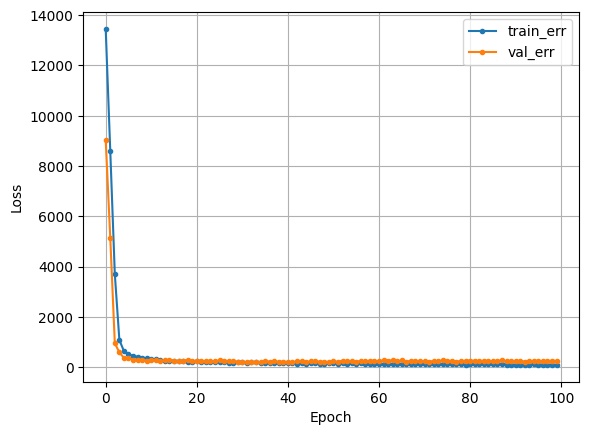

In [ ]:
dl_history_plot(hist3.history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


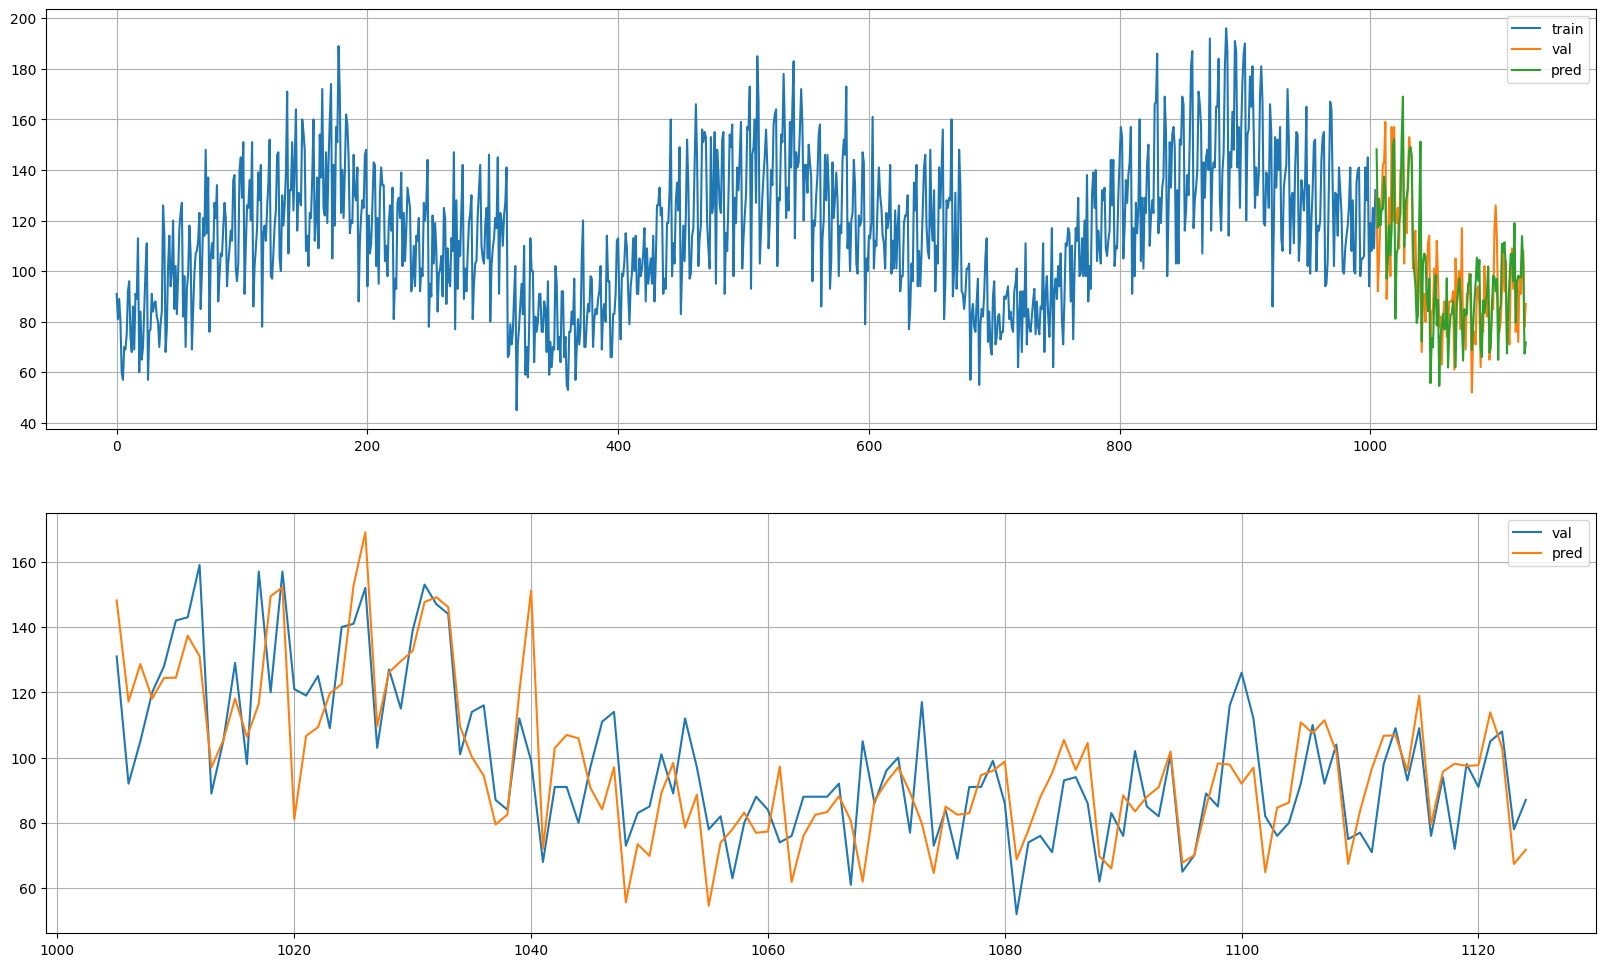

In [ ]:
plot_model_result(y_train_42, y_val_42, model_lstm_42.predict(x_val_42))

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
#위에서 준비완료

* **모델링**

In [ ]:
from keras.layers import MaxPooling1D

In [ ]:
model_cnn_42 = Sequential()

model_cnn_42.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                        input_shape=(x_train_42.shape[1], x_train_42.shape[2])))
model_cnn_42.add(MaxPooling1D(pool_size=2))
model_cnn_42.add(BatchNormalization())

model_cnn_42.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_cnn_42.add(MaxPooling1D(pool_size=2))
model_cnn_42.add(BatchNormalization())

model_cnn_42.add(Dropout(0.2))

model_cnn_42.add(Flatten())
model_cnn_42.add(Dense(50, activation='relu'))
model_cnn_42.add(Dense(1))

model_cnn_42.compile(optimizer='adam', loss='mean_squared_error')

hist3_cnn = model_cnn_42.fit(x_train_42, y_train_42, epochs=100, batch_size=16, validation_data=(x_val_42, y_val_42), verbose=0)


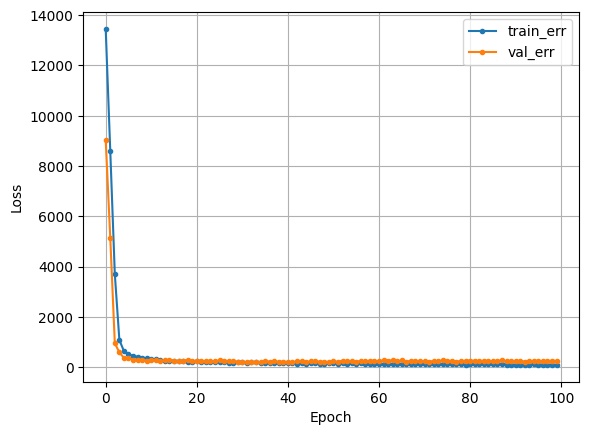

In [ ]:
dl_history_plot(hist3.history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


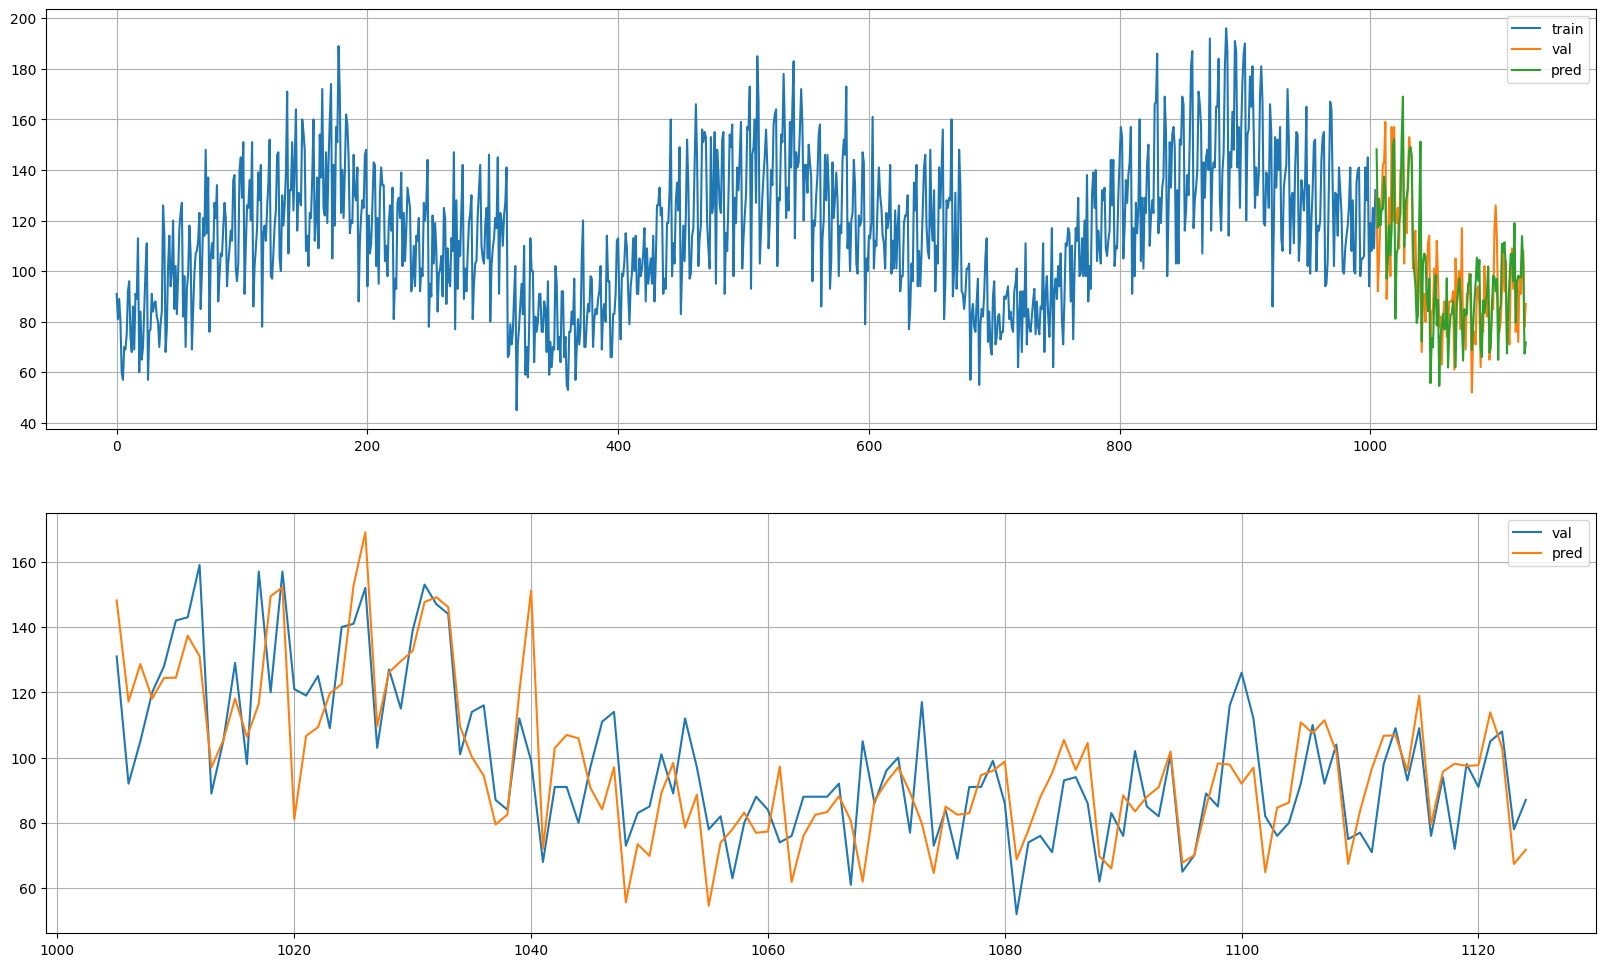

In [ ]:
plot_model_result(y_train_42, y_val_42, model_lstm_42.predict(x_val_42))

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
from datetime import timedelta
import holidays
from sklearn.preprocessing import StandardScaler
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)
def preproc3d(data, timesteps, y_scale = False, generate_test = False) :
    x = data.drop(['Date','Date_2', 'target'], axis = 1)
    y = data.loc[:, 'target']

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['Day'] = pd.Categorical(x['Day'] ,categories=range(1, 32),ordered=True)
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Day'])
    col_names = list(x)


    # 스케일링
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan


    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)
    if generate_test == True :
        print("temporalized")
        return x3, y3, y_min, y_max


    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val

def make_dataset(sales, orders, oil_price, Product_ID, Store_ID=44, y_scale=True, timesteps=7, generate_test=False):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==Store_ID) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==Store_ID, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.weekday # 요일 추출 (0: 월요일, 6: 일요일)
    temp3['Month'] = temp3['Date'].dt.month
    temp3['Day']=temp3['Date'].dt.day

    # 2일뒤 요일
    temp3['Date_2']=temp3['Date']+timedelta(2)
    temp3['Day+2']=temp3['Date_2'].dt.day
    temp3['Weekday+2']=temp3['Date_2'].dt.weekday

    temp3['Qty_1ago'] = temp3['Qty'].shift(1) #1일전 매출
    temp3['Qty_2ago'] = temp3['Qty'].shift(2) #2일전 매출
    temp3['Qty_last week'] = temp3['Qty'].shift(7) #일주일전 매출

    # 평균 판매량(7일, 14일)
    temp3['MA_7'] = temp3['Qty'].rolling(window=7).mean()
    temp3['MA_14'] = temp3['Qty'].rolling(window=14).mean()

    # 판매량 변화율
    temp3['Qty_diff_1'] = temp3['Qty'].diff(1)

    # 미국 공휴일 인스턴스 생성
    us_holidays = holidays.US()
    # 미국 공휴일 여부 확인 (1: 공휴일, 0: 비공휴일)
    temp3['holiday'] = temp3['Date'].apply(lambda x: 1 if x in us_holidays else 0)

    # 주말
    temp3['weekend']=np.where(temp3['WeekDay']>=5,1,0)

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    # 결측치를 이전값과 이후값의 평균으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    # 첫번째 또는 마지막 값이 결측치인 경우 이전/이후 값으로 채우기
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()
    temp3.dropna(inplace = True)



    # 분할
    if generate_test == True :
        x_test, y_test, y_min , y_max = preproc3d(temp3, timesteps, generate_test = generate_test)
        return x_test, y_test, y_min, y_max
    else:
      x_train, x_val, y_train, y_val = preproc3d(temp3, timesteps, generate_test = generate_test)

      return x_train, x_val, y_train, y_val


## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
x_test_42, y_test_42, y_42_min ,y_42_max = make_dataset(sales, orders, oil_price , Product_ID=42, generate_test=True)


temporalized


In [ ]:
y_test_42

array([ 91.,  81.,  89., ..., 108.,  78.,  87.])

* 예측해보기

In [ ]:
import numpy as np

print("NaN values in y_test_42:", np.isnan(y_test_42).sum())
print("NaN values in y_pred_lstm_42:", np.isnan(y_pred_lstm_42).sum())


NaN values in y_test_42: 0
NaN values in y_pred_lstm_42: 0


In [ ]:
y_pred_lstm_42 = model_lstm_42.predict(x_test_42)

print('MAE : ', mean_absolute_error(y_test_42, y_pred_lstm_42))
print('MAPE : ',mean_absolute_percentage_error(y_test_42, y_pred_lstm_42))
print('R2 : ',r2_score(y_test_42, y_pred_lstm_42))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE :  5.016273288302951
MAPE :  0.04686850328737474
R2 :  0.9331720239444335


In [ ]:
y_pred_cnn_42 = model_cnn_42.predict(x_test_42)

print('MAE : ', mean_absolute_error(y_test_42, y_pred_cnn_42))
print('MAPE : ',mean_absolute_percentage_error(y_test_42, y_pred_cnn_42))
print('R2 : ',r2_score(y_test_42, y_pred_cnn_42))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE :  6.913879180908203
MAPE :  0.06690507229121401
R2 :  0.8951193062552237


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock=30, price=10000) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [ ]:
#product 42
inv_simulator(y_test_42, y_pred_lstm_42, safe_stock=30, price=10000)

일평균 재고량     : 88.443
일평균 재고 금액  : 884430.0
일평균 재고회전율 : 1.337
기회손실 수량     : -786.0


,y,pred,base_stock,close_stock,order,receive,lost
0,91.0,97.0,121,30,91,91,0.0
1,81.0,86.0,111,30,83,81,0.0
2,89.0,91.0,121,32,61,91,0.0
3,80.0,83.0,115,35,53,83,0.0
4,60.0,63.0,96,36,63,61,0.0
...,...,...,...,...,...,...,...
1118,72.0,98.0,130,58,70,64,0.0
1119,98.0,97.0,119,21,123,61,0.0
1120,91.0,98.0,91,0,133,70,0.0
1121,105.0,114.0,123,18,79,123,0.0
